In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path

In [3]:
def parse_strace_summary(filename):
    syscalls = {}

    with open(filename, 'r') as file:
        lines = file.readlines()

        for line in lines[2:-2]:  # Skipping the headers
            parts = line.split()
            if len(parts) < 5:
                continue
            
            # Check if the 'errors' column is populated
            if parts[4].isdigit():
                syscall = parts[5]
            else:
                syscall = parts[4]
                
            calls = math.log(int(parts[3]))
            syscalls[syscall] = calls

    return syscalls

# Testing the function
sp_path = Path("syscall_profiles/")

sp_dict = {
    file.name.split('.')[0]: parse_strace_summary(file)
    for file in sp_path.iterdir()}

total_sp = {}
print(f"Num bins: {len(sp_dict)}")
for k, v in sp_dict.items():
    for sc, ct in v.items():
        if sc not in total_sp:
            total_sp[sc] = ct
        else:
            total_sp[sc] += ct
        if sc == "prlimit64":
            print(k)
print(f"Num syscalls: {len(total_sp)}")

Num bins: 8
paho-bench
bash
sysbench
pbbs
runtime
sqlite3
memcached-testapp
Num syscalls: 103


In [4]:
sorted_total_sp = {k: v for k, v in sorted(total_sp.items(), key=lambda item: item[1])[::-1]}
print(sorted_total_sp)

{'read': 51.07115933482175, 'write': 50.09002858515963, 'clock_nanosleep': 41.634824384691996, 'mmap': 41.01007654308474, 'openat': 39.73277585463864, 'close': 37.52859639108411, 'fstat': 33.094485381864686, 'mprotect': 32.93449936717178, 'pread64': 31.28034959591348, 'brk': 28.602515025903326, 'lseek': 28.513352507074096, 'rt_sigaction': 27.750838573033537, 'stat': 25.571087842084218, 'futex': 22.372733135469677, 'rt_sigprocmask': 21.882445861107076, 'getpid': 21.221105620478788, 'writev': 20.754382919583797, 'munmap': 20.567297602366775, 'fcntl': 20.499395621675887, 'access': 20.099865090273937, 'recvfrom': 18.094041936302055, 'getuid': 18.05965348527477, 'geteuid': 17.874808136892227, 'arch_prctl': 17.861323482596067, 'poll': 17.809216660276206, 'getrusage': 17.727267928114493, 'getgid': 17.715881946171944, 'getegid': 17.715881946171944, 'lstat': 16.997842723171782, 'ioctl': 16.095375491802045, 'clone': 15.619698473099254, 'set_robust_list': 15.275155747534061, 'prlimit64': 14.27136

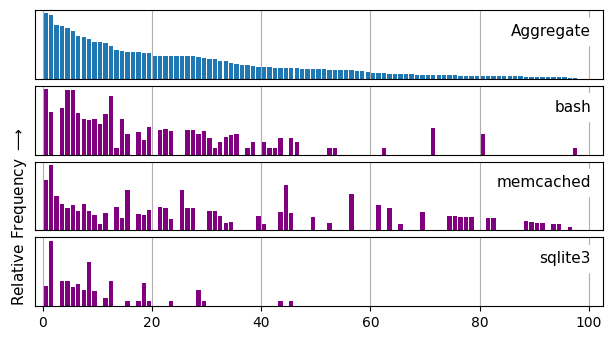

In [75]:
N = None

def top_n(d):
    return list(d)[:N]

xscale = top_n(sorted_total_sp.keys())

def plot_profile(ax, lst):
    vals = np.array(top_n(lst), dtype=float)
    vals /= np.sum(vals)
    p1 = ax.bar(xscale, vals, color='purple')
    

apps = {
    "bash": "bash",
    "memcached-testapp": "memcached",
    "sqlite3": "sqlite3"
}

fig, axs = plt.subplots(1+len(apps), 1, figsize=(6, 3.5))

# Total
vals = np.array(top_n(sorted_total_sp.values()), dtype=float)
vals /= np.sum(vals)
p1 = axs[0].bar(xscale, vals)
axs[0].text(
    0.98, 0.8, "Aggregate", transform=axs[0].transAxes, ha='right', va='top',
    backgroundcolor='white', fontsize=11)

for ax, (app, desc) in zip(axs[1:], apps.items()):
    sp_app = sp_dict[app]
    sorted_sp = [sp_app[x] if x in sp_app else 0 for x in xscale]
    plot_profile(ax, sorted_sp)
    ax.text(
        0.98, 0.8, desc, transform=ax.transAxes, ha='right', va='top',
        backgroundcolor='white', fontsize=11)

xticks = np.array([0, 20, 40, 60, 80, 100])
for ax in axs:
    ax.grid()
    ax.set_yticks([])
    ax.set_xlim(-2, 102)
    ax.set_xticks(xticks - 0.5)
for ax in axs[:-1]:
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

_ = axs[-1].set_xticklabels(xticks)
fig.tight_layout(h_pad=0.5)

axs[-1].set_ylabel(
    "Relative Frequency $\longrightarrow$", loc='bottom', fontsize=11)
fig.savefig("figures/syscall_profile.pdf", bbox_inches='tight')